# ExioML: Eco-economic dataset for Machine Learning in Global Sectoral Sustainability
This Jupyter Notebook demonstrates the pre-processing of the ExioML dataset for our paper. It contains two parts: The factor accounting table and the footprint network. ExioML is derived from the open-source Environmental-Extend Multi-regional Input Ouput (EE-MRIO) dataset, ExioBase 3.8. This notebook enables a high level of customise of the selection of interest factors. In our paper, 4 essential factors interested by the eco-economic research community, which are emissions ($F$), population ($P$), GDP ($G$), and energy consumption ($E$) indicated by the Kaya Identity are selected:

$$F = P \times \frac{G}{P} \times \frac{E}{G} \times \frac{F}{E}.$$

ExioML comprises two pivotal elements. Firstly, factor accounting, presented in a tabular format, delineates heterogeneous characteristics of various sectors, a subset of the emission extension table with selected factors from ExioBase. Secondly, the footprint network, depicted in graph format, describes the transfer of the resource footprints among sectors. The construction details are explained in the Appendix. Each element is divided into two categories: The product-by-product (PxP) dataset encompasses 200 products, and the industry-by-industry (IxI) dataset covers 163 industries, crossing 49 regions spanning 1995 to 2022. 

## Construction of Footprint Network

In [1]:
# !pip3 install -q pymrio

In [1]:
import pandas as pd
import numpy as np
import pymrio
import sys
import os
import pymrio.tools.ioutil as ioutil
from pymrio.tools.iomath import calc_L, calc_M
import warnings
warnings.filterwarnings("ignore")

# Account name is Value Added, Employment, GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007), Energy Carrier Net Total

def read_exio(year, type):
    print(f"Current loading year: {year}")
    path = '../../data/exio3/exio3/IOT_'+str(year)+f'_{type}.zip'
    print(path)
    exio = pymrio.parse_exiobase3(path=path)
    return exio

### EE-MRIO framework
Calculation of environmental footprint networks involves high-dimensional matrix operation. We utilised GPUs to speed up the calculation. The construction leverages the MRIO model by following steps. Initially, the column vector $x$ symbolizes the global economy's output, with each element $x^r$ representing the total output of region $r$. This could be determined by transaction matrix $Z$ and demand matrix $Y$:

$$\begin{pmatrix}
    x^1 \\
    x^2 \\
    \vdots \\
    x^m \\
    \end{pmatrix} = \begin{pmatrix}
    Z^{11} & Z^{12} & \cdots & Z^{1m} \\
    Z^{21} & Z^{22} & \cdots & Z^{2m} \\
    \vdots  & \vdots  & \ddots & \vdots  \\
    Z^{m1} & Z^{m2} & \cdots & Z^{mm}
    \end{pmatrix} + \begin{pmatrix}
    \sum_s y^{1s} \\
    \sum_s y^{2s} \\
    \vdots\\
    \sum_s y^{ms} \\
    \end{pmatrix}.$$

$Z$ indicates the transaction matrix for $m$ regions, and $Z^{rs}$ is the inter-regional requirement from region $r$ to region $s$. $y^{rs}$ is the final demand from region $r$ to region $s$.

The direct requirement matrix $A$, indicative of technological efficiency, is derived by multiplying the transaction matrix $Z$ with the diagonalized, inverted vector $\hat{x}^{-1}$:

$$A = Z \hat{x}^{-1}.$$

Further, the economy's output vector $x$ is expressible via the Leontief matrix $L$:

$$x = (I - A)^{-1} y = Ly.$$

This framework can incorporate environmental accounting, such as energy consumption and greenhouse gas (GHG) emissions, with the factor represented by $F$. The coefficient $S$ normalizes this factor against the output $x$:

$$S = F \hat{x}^{-1}.$$

Finally, the footprint flow networks $D$ could be determined by:

$$ D = SLy.$$

### Calculation on CPUs

In [3]:
def calc_x_diag(exio):
  Y = exio.Y
  L = calc_L(exio.A)
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
  Y_diag = ioutil.diagonalize_columns_to_sectors(Y_agg)
  x_diag = L @ Y_diag
  return x_diag

def exio_columns(exio):
  return exio.A.columns, exio.A.groupby(level=0, axis=1).sum().columns

def calc_x_diag_agg(exio):
  Y = exio.Y
  L = calc_L(exio.A)
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
  Y_diag = ioutil.diagonalize_columns_to_sectors(Y_agg)
  x_diag = L @ Y_diag
  return x_diag

def calc_flow_matrix(exio, x_diag, account_name):
  e = exio.impacts.S.T[account_name].values # Factors in impacts or satellite account
  e = np.diag(e.flatten())
  col, ind = exio_columns(exio)
  e_diag = pd.DataFrame(e, columns= col, index= col)
  flow_matrix = e_diag @ x_diag
  return flow_matrix

def groupbys(df):
  return df.groupby(level="region", axis=1).sum().groupby(level="region", axis=0).sum()

### GPUs acceleration

In [ ]:
# !pip3 install torch torchvision torchaudio

In [3]:
import pandas as pd
import numpy as np
import torch

def calc_x_diag(exio):
  Y = exio.Y
  L = calc_L(exio.A)
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
  Y_diag = ioutil.diagonalize_columns_to_sectors(Y_agg)
  x_diag = L @ Y_diag
  return x_diag


def calc_x_diag_gpu(exio):
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")

    # Convert DataFrame to PyTorch tensor and move to GPU
    L = torch.tensor(calc_L_gpu(exio).values).to(device)
    Y_agg = exio.Y.groupby(level="region", axis=1, sort=False).sum()
    Y_diag = ioutil.diagonalize_columns_to_sectors(Y_agg)

    # Diagonalize Y
    Y_diag = torch.tensor(np.float32(Y_diag.values)).to(device)

    # Matrix multiplication
    x_diag = torch.mm(L, Y_diag)

    # Convert back to CPU and to DataFrame for further processing
    x_diag = pd.DataFrame(x_diag.cpu().numpy(), index=exio.A.index, columns=exio.A.columns)

    return x_diag

def calc_flow_matrix_gpu(exio, x_diag, e):
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")

    e = torch.tensor(np.float32(e.values)).to(device)
    e = torch.diag_embed(e)

    # Convert x_diag to tensor and move to GPU
    x_diag_tensor = torch.tensor(x_diag.values).to(device)

    flow_matrix = torch.mm(e, x_diag_tensor)

    # Convert back to CPU and to DataFrame
    flow_matrix = pd.DataFrame(flow_matrix.cpu().numpy(), index=x_diag.index, columns=x_diag.columns)

    return flow_matrix

def calc_L_gpu(exio):
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")

    # Convert DataFrame to PyTorch tensor and move to GPU
    A = torch.tensor(np.float32(exio.A.values)).to(device)

    # Create identity matrix
    I = torch.eye(A.shape[0], device=device)

    # Calculate the inverse of (I - A)
    L = torch.inverse(I - A)

    # Convert back to CPU and to DataFrame for further processing
    L = pd.DataFrame(L.cpu().numpy(), index=exio.A.index, columns=exio.A.columns)

    return L

def get_F(exio, account_name):
  return exio.impacts.F.T[account_name]

def get_S(exio, account_name):
  return exio.impacts.S.T[account_name]

### CPUs VS GPUs
Speed comparison between CPUs and GPUs for single year MRIO table calculation.

In [4]:
import time

year = 1995
exio = read_exio(year, "IxI")
account_name = 'Value Added'

Current loading year: 1995
../../data/exio3/exio3/IOT_1995_IxI.zip


The GPUs run 3 times faster than CPUs for the same calculation. However, Apple GPUs only support 16-bit floating point operations, which may lead to precision loss.

In [7]:
# Record the running time for CPUs
start_time = time.time()
x_diag = calc_x_diag(exio)
flow_CPU = calc_flow_matrix(exio, x_diag, account_name)

print(f"CPUs time taken: {time.time() - start_time:.2f} seconds")

# Record the running time for GPUs
start_time = time.time()
x_diag = calc_x_diag_gpu(exio)
flow_GPU = calc_flow_matrix_gpu(exio, x_diag, get_S(exio, account_name))

print(f"GPUs time taken: {time.time() - start_time:.2f} seconds")

CPUs time taken: 18.42 seconds
GPUs time taken: 7.22 seconds


In [14]:
flow_CPU.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                           0.000000e+00   
       Cultivation of wheat                                7.473430e-07   
       Cultivation of cereal grains nec                    1.863986e-06   
       Cultivation of vegetables, fruit, nuts              5.078753e-07   
       Cultivation of oil seeds                            2.834442e-07   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                              29.469061   
       Cultivation of cereal grains nec                   0.001956   
       Cultivation of vegetables, fruit, nuts             0.000808   
       Cultivation of oil seeds                           0.000437   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.003321   
       Cultivation of cereal grains nec                             101.581157   
       Cultivation of vegetables, fruit, nuts                         0.002433   
       Cultivation of oil seeds                                       0.001313   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                            0.000000   
       Cultivation of wheat                                                 0.014418   
       Cultivation of cereal grains nec                                     0.026437   
       Cultivation of vegetables, fruit, nuts                             564.936024   
       Cultivation of oil seeds                                             0.005737   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                              0.000000   
       Cultivation of wheat                                   0.000446   
       Cultivation of cereal grains nec                       0.000691   
       Cultivation of vegetables, fruit, nuts                 0.000283   
       Cultivation of oil seeds                              19.612680   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                           0.000000   
       Cultivation of wheat                                                0.000220   
       Cultivation of cereal grains nec                                    0.000349   
       Cultivation of vegetables, fruit, nuts                              0.000140   
       Cultivation of oil seeds                                            0.000073   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [15]:
flow_GPU.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                           0.000000e+00   
       Cultivation of wheat                                7.473113e-07   
       Cultivation of cereal grains nec                    1.863925e-06   
       Cultivation of vegetables, fruit, nuts              5.078578e-07   
       Cultivation of oil seeds                            2.834348e-07   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                              29.469049   
       Cultivation of cereal grains nec                   0.001956   
       Cultivation of vegetables, fruit, nuts             0.000808   
       Cultivation of oil seeds                           0.000437   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.003321   
       Cultivation of cereal grains nec                             101.581100   
       Cultivation of vegetables, fruit, nuts                         0.002433   
       Cultivation of oil seeds                                       0.001313   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                            0.000000   
       Cultivation of wheat                                                 0.014418   
       Cultivation of cereal grains nec                                     0.026436   
       Cultivation of vegetables, fruit, nuts                             564.935852   
       Cultivation of oil seeds                                             0.005737   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                              0.000000   
       Cultivation of wheat                                   0.000446   
       Cultivation of cereal grains nec                       0.000691   
       Cultivation of vegetables, fruit, nuts                 0.000283   
       Cultivation of oil seeds                              19.612673   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                           0.000000   
       Cultivation of wheat                                                0.000220   
       Cultivation of cereal grains nec                                    0.000349   
       Cultivation of vegetables, fruit, nuts                              0.000140   
       Cultivation of oil seeds                                            0.000073   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [4]:
def fliter_melt(network, nlargest = 100000, year = 1995):
    df = network.copy()
    
    # Reset the index and column
    df.index = ['_'.join(index) for index in df.index]
    df.columns = ['_'.join(col) for col in df.columns]

    # Reset the index and column
    df_reset = df.reset_index().rename(columns={'index': 'RowLabel'})
    df_reset = df.reset_index().rename(columns={'index': 'RowLabel'})

    # Melting the DataFrame
    melted_df = df_reset.melt(id_vars=['RowLabel'], var_name='ColumnLabel', value_name='Value')

    # Rename the columns
    final_df = melted_df.rename(columns={'RowLabel': 'Source', 'ColumnLabel': 'Target', 'Value': 'Value'})
    
    final_df["Year"] = year
    final_df = final_df.nlargest(nlargest, 'Value')
    return final_df


In [9]:
df = fliter_melt(flow_CPU, 10, year)
df

,Source,Target,Value,Year
7988,AT_Cultivation of wheat,AT_Cultivation of wheat,29.469061,1995
15976,AT_Cultivation of cereal grains nec,AT_Cultivation of cereal grains nec,101.581157,1995
23964,"AT_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",564.936024,1995
24098,AT_Health and social work (85),"AT_Cultivation of vegetables, fruit, nuts",10.313460,1995
24453,"CY_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",11.868720,1995
...,...,...,...,...
63776166,WM_Other business activities (74),WM_Other service activities (93),138.155816,1995
63776191,"WM_Recreational, cultural and sporting activit...",WM_Other service activities (93),17.454929,1995
63776192,WM_Other service activities (93),WM_Other service activities (93),2089.471147,1995
63783528,WA_Private households with employed persons (95),WM_Private households with employed persons (95),15.393682,1995


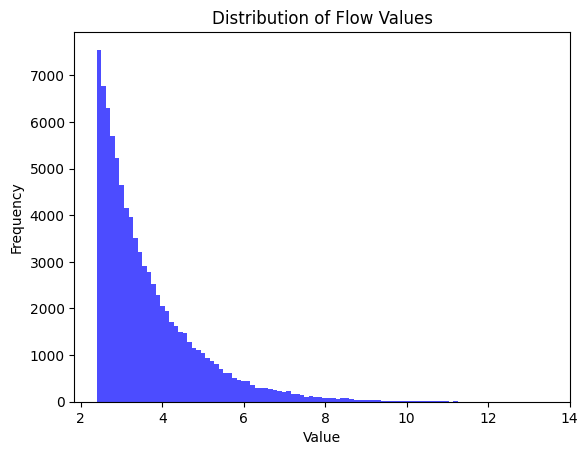

In [62]:
# Draw the distribution of the flow values
import matplotlib.pyplot as plt

# Log transformation
df['Value'] = np.log1p(df['Value'])

plt.hist(df['Value'], bins=100, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Flow Values')
plt.show()

In [17]:
df.head(10)

,Source,Target,Value,Year
7988,AT_Cultivation of wheat,AT_Cultivation of wheat,29.469061,1995
15976,AT_Cultivation of cereal grains nec,AT_Cultivation of cereal grains nec,101.581157,1995
23964,"AT_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",564.936024,1995
24098,AT_Health and social work (85),"AT_Cultivation of vegetables, fruit, nuts",10.313460,1995
24453,"CY_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",11.868720,1995
24779,"DE_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",17.822464,1995
26083,"HU_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",17.854958,1995
26409,"IT_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",94.655588,1995
31136,"WA_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",29.465886,1995
31299,"WL_Cultivation of vegetables, fruit, nuts","AT_Cultivation of vegetables, fruit, nuts",50.766874,1995


### Data Preprocessing


In [5]:
type = "PxP"
account_name = 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'
folder_name = "emission"

for year in range(1995, 1996):
    exio = read_exio(year, type)
    
    x_diag = calc_x_diag(exio)
    flow = calc_flow_matrix(exio, x_diag, account_name)

    df = fliter_melt(flow, 1000000, year)
    df.to_csv(f'../../data/processed_data/flow/{folder_name}/{year}_{type}.csv', index=False)

Current loading year: 1995
../../data/exio3/exio3/IOT_1995_PxP.zip


### Concat the Multi-dimensional Footprint Network

In [37]:
from functools import reduce

def merge_dfs(df1, df2):
    return df1.merge(df2, on=['Source', 'Target', "Year"], how='inner')

def footprint_netwrok(type = "IxI", year = 1995):
    value_df = pd.read_csv(f'../../data/processed_data/flow/value_added/{year}_{type}.csv')
    employment_df = pd.read_csv(f'../../data/processed_data/flow/employment/{year}_{type}.csv')
    energy_df = pd.read_csv(f'../../data/processed_data/flow/energy/{year}_{type}.csv')
    emission_df = pd.read_csv(f'../../data/processed_data/flow/emission/{year}_{type}.csv')

    value_df.rename(columns={'Value': 'Value Added [M.EUR]'}, inplace=True)
    employment_df = employment_df.rename(columns={'Value': 'Employment [1000 p.]'})
    energy_df = energy_df.rename(columns={'Value': 'Energy Carrier Net Total [TJ]'})
    emission_df = emission_df.rename(columns={'Value': 'GHG emissions [kg CO2 eq.]'})

    dfs = [value_df, employment_df, energy_df, emission_df]
    
    merged_df = reduce(merge_dfs, dfs)
    merged_df = merged_df[["Source", "Target", "Value Added [M.EUR]","Employment [1000 p.]", "Energy Carrier Net Total [TJ]","GHG emissions [kg CO2 eq.]", "Year"]]
    return merged_df

In [ ]:
type = "PxP"

for year in range(1995, 2023):
    network = footprint_netwrok(type, year)
    print(network.shape)
    network.to_csv(f'../../data/processed_data/flow/output/{type}_{year}.csv', index=False)

In [48]:
networks = []
type = "PxP"

for year in range(1995, 2023):
    network = pd.read_csv(f'../../data/processed_data/flow/output/{type}_{year}.csv')
    networks.append(network)
    
footprint = pd.concat(networks)
footprint.to_csv(f'../../data/processed_data/flow/footprint/footprint_{type}.csv', index=False)

In [49]:
footprint

,Source,Target,Value Added [M.EUR],Employment [1000 p.],Energy Carrier Net Total [TJ],GHG emissions [kg CO2 eq.],Year
0,US_Public administration and defence services;...,US_Public administration and defence services;...,673423.344123,7269.089691,2.325718e+06,7.407185e+10,1995
1,US_Real estate services (70),US_Real estate services (70),450882.470826,1455.976588,6.514840e+05,1.482128e+10,1995
2,US_Health and social work services (85),US_Health and social work services (85),324486.261218,13686.916418,6.745730e+05,1.588398e+10,1995
3,JP_Health and social work services (85),JP_Health and social work services (85),313978.758895,5497.145770,6.579442e+05,2.963452e+10,1995
4,JP_Construction work (45),JP_Construction work (45),306735.394505,6225.034449,1.980293e+05,1.134496e+10,1995
...,...,...,...,...,...,...,...
303381,WA_Ceramic goods,WA_Printed matter and recorded media (22),1.437569,0.349967,4.731149e+01,3.549053e+06,2022
303382,IN_Paddy rice,BE_Chemicals nec,1.437565,1.240376,3.281338e+01,1.557723e+07,2022
303383,WF_Aluminium and aluminium products,US_Food products nec,1.437538,0.269002,1.706420e+01,1.817021e+06,2022
303384,WA_P- and other fertiliser,WF_Beverages,1.437530,0.896888,4.028581e+01,4.845469e+06,2022
